In [4]:
# requruiments

!pip install requests
!pip install time
!pip install pandas
!pip install numpy
!pip install matplotlib.pyplot
!pip install schedule

{'prices': [[1754676269600, 116666.67964128975], [1754679854221, 116506.94482165811], [1754683440556, 116449.75033943536], [1754687378840, 116834.12792892547], [1754690572050, 116951.43064524583], [1754694357409, 116895.02084894278], [1754698007589, 116686.72473635004], [1754701768000, 116611.67486663083], [1754705345258, 116566.64327820552], [1754708662156, 116441.19539824275], [1754712236094, 116397.67926922366], [1754716145226, 116423.53362042307], [1754719783458, 116708.22561872333], [1754723086588, 116653.89502137293], [1754726995122, 116768.27206611432], [1754730579954, 117077.76520803696], [1754734272754, 117533.0938367717], [1754737463919, 117441.67571151303], [1754741371285, 117108.46189936704], [1754744495758, 117097.50306534256], [1754748057348, 116996.92141091316], [1754751863441, 116965.931269068], [1754755470776, 116845.40417692252], [1754759007918, 116667.73371007525], [1754762940518, 116660.84198406573], [1754766516104, 116647.05734217919], [1754770170112, 116541.075842

In [28]:
import requests
import time

def fetch_data():
    coin_id = "bitcoin"
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart/range"

    to_ts = int(time.time())                 
    from_ts = to_ts - 90 * 24 * 60 * 60    

    params = {    
        "vs_currency": "usd",
        "from": from_ts,
        "to": to_ts        
    }

    response = requests.get(url, params=params)
    data = response.json()

    # print(data)

    return data

In [29]:
import pandas as pd
import numpy as np

data = fetch_data()

# def normalize_coingecko_series(data, field="prices", col="BTC"):
#     df = pd.DataFrame(data[field], columns=["ts_ms", col])
#     df["date"] = pd.to_datetime(df["ts_ms"], unit="ms", utc=True)
#     df = df.drop(columns=["ts_ms"]).drop_duplicates(subset=["date"]).sort_values("date")
#     df[col] = pd.to_numeric(df[col], errors="coerce")
#     df[col] = df[col].replace(0, np.nan)
#     df[col] = df[col].ffill(limit=3)
#     return df[["date", col]]

# btc_df = normalize_coingecko_series(data, col="BTC")
# btc_df.head()

def _to_df(series, value_name):
    df = pd.DataFrame(series, columns=["ts_ms", value_name])
    df["date_utc"] = pd.to_datetime(df["ts_ms"], unit="ms", utc=True)
    df = df.drop(columns=["ts_ms"]).sort_values("date_utc")
    df[value_name] = pd.to_numeric(df[value_name], errors="coerce").replace(0, np.nan)
    return df

def coingecko_to_daily_ohlcv(data_json):
    # Intraday price & volume frames
    prices_df = _to_df(data_json["prices"], "price")
    vols_df   = _to_df(data_json["total_volumes"], "vol_ccy")  # currency volume 

    # Align by nearest timestamp 
    tick = pd.merge_asof(
        prices_df.sort_values("date_utc"),
        vols_df.sort_values("date_utc"),
        on="date_utc",
        direction="nearest",
        tolerance=pd.Timedelta("5min"),
    )

    # cleanup
    tick["price"] = tick["price"].ffill(limit=3)
    tick = tick.dropna(subset=["price", "vol_ccy"]).set_index("date_utc").sort_index()

    # Approximate BTC volume = currency_volume / price
    tick["vol_btc"] = tick["vol_ccy"] / tick["price"]

    # Resample to daily
    ohlc = tick["price"].resample("1D").agg(
        Open="first",
        High="max",
        Low="min",
        Close="last"
    )

    vols = tick.resample("1D").agg(
        **{
            "Volume (BTC)": ("vol_btc", "sum"),
            "Volume (Currency)": ("vol_ccy", "sum"),
        }
    )

    daily = pd.concat([ohlc, vols], axis=1)
    daily.index.name = "Date"
    daily = daily.dropna(how="all")
    return daily

btc_daily = coingecko_to_daily_ohlcv(data)
btc_daily.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency)
Date,,,,,,
2025-08-12 00:00:00+00:00,118904.742411,120016.483177,118378.159359,119999.157380,6.725528e+06,8.019375e+11
2025-08-13 00:00:00+00:00,120106.097066,123066.190966,119019.987544,123066.190966,1.007006e+07,1.216444e+12
2025-08-14 00:00:00+00:00,123419.334447,123782.080087,117846.829393,118327.472539,1.460687e+07,1.759637e+12
2025-08-15 00:00:00+00:00,118387.769403,119160.515384,117000.411187,117805.211959,1.183816e+07,1.401488e+12
2025-08-16 00:00:00+00:00,117396.518524,117954.973339,117396.518524,117484.755854,7.240506e+06,8.518722e+11


In [30]:
import numpy as np 
import math

# Sharp Ratio Grading Thresholds:
# Less than 1: Bad
# 1 – 1.99: Adequate/good
# 2 – 2.99: Very good
# Greater than 3: Excellent

# prices: array of prices
# rf: risk-free rate of return
def risk_return(prices, rf=0.04):
    returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
    risk = np.std(returns)
    reward = np.mean(returns)
    return reward - rf / risk

print(risk_return(btc_daily["Close"]))

# over 90 days
def volatility(prices):
    returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
    average = sum(returns) / len(returns)
    diffs = []
    for daily_return in returns:
        diffs.append((daily_return - average)**2)
    sd = [math.sqrt(diff/len(returns)) for diff in diffs]
    crypto_volatility = [round(n * math.sqrt(365) * 100, 2) for n in sd]
    return crypto_volatility

btc_volatility = volatility(btc_daily["Close"])
print(btc_volatility)

-2.056580873201214
[5.38, 7.52, 0.65, 0.31, 1.13, 2.43, 5.43, 2.76, 3.49, 7.79, 2.2, 3.02, 5.4, 3.25, 0.58, 1.98, 7.18, 0.74, 0.84, 0.48, 5.31, 1.57, 0.6, 0.99, 0.93, 2.24, 1.96, 1.03, 4.6, 2.56, 1.71, 0.08, 0.44, 1.03, 2.98, 0.22, 0.38, 2.0, 0.53, 0.17, 4.8, 0.69, 2.36, 6.91, 0.74, 0.25, 4.56, 4.25, 0.22, 7.21, 4.12, 4.21, 0.13, 1.62, 3.36, 4.73, 2.37, 2.28, 12.77, 4.62, 8.11, 0.51, 3.92, 4.14, 4.87, 1.57, 0.48, 3.67, 3.67, 3.0, 3.4, 5.67, 2.1, 1.49, 5.71, 0.89, 1.3, 3.34, 5.91, 3.52, 1.07, 0.33, 5.78, 9.73, 5.34, 4.46, 4.94, 2.31, 4.92, 2.98]


/var/folders/n0/8kk1p2bs4_56mk71mqvwlbs40000gn/T/ipykernel_84785/1040983200.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]
/var/folders/n0/8kk1p2bs4_56mk71mqvwlbs40000gn/T/ipykernel_84785/1040983200.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]


In [31]:
import matplotlib.pyplot as plt

# def plot_graph(btc_daily):
#     plt.figure(figsize=(10,5))
#     plt.plot(btc_daily.index, btc_daily["Close"], label="BTC Daily Close")
#     plt.title("Bitcoin Daily Closing Prices")
#     plt.xlabel("Date")
#     plt.ylabel("Price (USD)")
#     plt.legend()
#     plt.show()

# def plot_risk_graph():
#     plt.figure(figsize=(10,5))
#     plt.plot(btc_daily["date"][1:], btc_volatility, color="blue", label="BTC Daily Volatility")
#     plt.title("Bitcoin Daily Volatility")
#     plt.xlabel("Date")
#     plt.ylabel("Volatility")
#     plt.legend()
#     plt.show()

def plot_combined_graph(btc_daily, btc_volatility):
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.plot(btc_daily.index, btc_daily["Close"], color="orange", label="BTC Daily Close")
    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price (USD)", color="orange")
    ax1.tick_params(axis="y", labelcolor="orange")

    ax2 = ax1.twinx()
    ax2.plot(btc_daily.index[1:], btc_volatility, color="blue", label="BTC Volatility")
    ax2.set_ylabel("Volatility (%)", color="blue")
    ax2.tick_params(axis="y", labelcolor="blue")

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc="upper left")

    plt.title("Bitcoin Daily Closing Price and Volatility")
    plt.tight_layout()
    plt.show()

/var/folders/n0/8kk1p2bs4_56mk71mqvwlbs40000gn/T/ipykernel_84785/1040983200.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  returns = [((prices[i] - prices[i-1]) / prices[i-1]) for i in range(1, len(prices))]


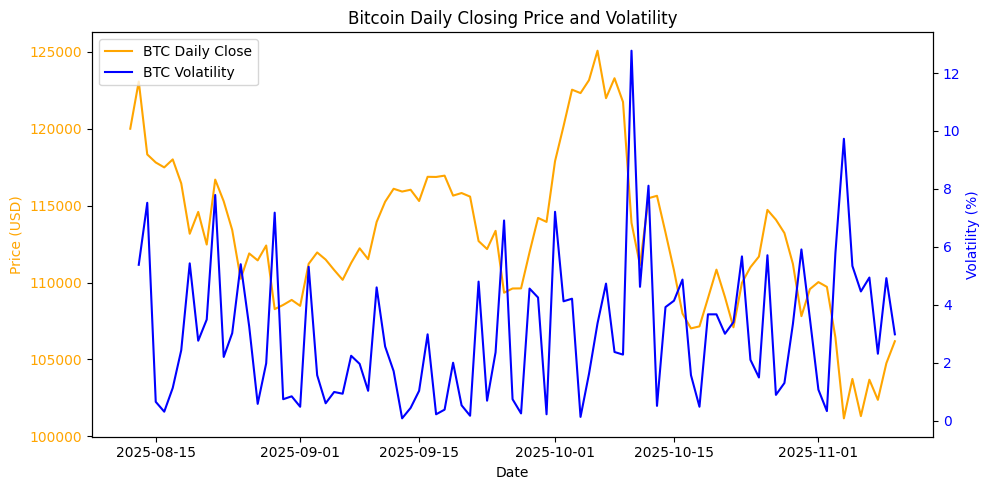

In [33]:
import schedule
import requests
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def schedule_graph():
    data = fetch_data()
    btc_daily = coingecko_to_daily_ohlcv(data)
    btc_volatility = volatility(btc_daily["Close"])
    plot_combined_graph(btc_daily, btc_volatility)

schedule_graph()
    

# schedule.every().day.at("22:39").do(schedule_graph)
# print("Scheduler started. Will fetch and graph data every day at 09:00.")

# while True:
#     schedule.run_pending()
#     time.sleep(60)